# Bayesian Geolocation
## Danny Wolf & Taylor Sheneman - Report 4
### Computational Bayesian Statistics, Fall 2016

*You've just been abducted by aliens. (Yes, the conspiracy theorists are right.) After a bevy of horrific experiments, they set you back on Earth, right in the middle of...where? Could we figure out where in the world you were placed, based on some easily measurable local data?*

A plethora of data exist for conditions around the world, relating to both natural and manmade patterns. In this report, we seek to demonstrate how one might go about locating a person on the earth, using Bayesian methods, based on the answers to a few simple questions that could be relayed over, say, a phone call to a kidnapping hotline.

This report is one possible response to the above question, using the local area of one state (Massachusetts), one type of natural data, and one observation of manmade patterns. So, the more specific question is reframed as such:

*So, you've been set down somewhere in Massachusetts. Phew, not too far from school.*

* You notice that it's (raining/not raining).

*You walk for a while, and eventually*

* You come across a street, named (road name).

*Based on these two data points, where were you set down?*

In [1]:
from __future__ import print_function, division

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.style.use('ggplot')
import random

import thinkbayes2
from thinkbayes2 import Pmf, Cdf, Suite, Joint, MakeBinomialPmf, Beta, MakeMixture
import thinkplot

import scipy.stats as stats

from itertools import product
from operator import truediv

% matplotlib inline

import gdal
import gdalconst

In [26]:
# imports for roads
import psycopg2
from shapely.geometry import mapping, shape, Point
import json


# haversine for km distance between long-lats
from math import radians, cos, sin, asin, sqrt

# http://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
def haversine(c1, c2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, c1 + c2)

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

Code adapted from http://gis.stackexchange.com/questions/97828/reading-zipped-esri-bil-files-with-python to process Band Interleaved by Line files, a rasterized image format commonly used to store and display various types of geographical and weather data.

In [2]:
class BilFile(object):

    def __init__(self, bil_file):
        self.bil_file = bil_file
        self.hdr_file = bil_file.split('.')[0]+'.hdr'

    def get_array(self, mask=None):
        self.nodatavalue, self.data = None, None
        gdal.GetDriverByName('EHdr').Register()
        img = gdal.Open(self.bil_file, gdalconst.GA_ReadOnly)
        band = img.GetRasterBand(1)
        self.nodatavalue = band.GetNoDataValue()
        self.ncol = img.RasterXSize
        self.nrow = img.RasterYSize
        geotransform = img.GetGeoTransform()
        self.originX = geotransform[0]
        self.originY = geotransform[3]
        self.pixelWidth = geotransform[1]
        self.pixelHeight = geotransform[5]
        self.data = band.ReadAsArray()
        return self.nodatavalue, self.data

Pulls the PRISM monthly normals datasets (http://prism.oregonstate.edu/normals/) from our locally stored copies and stores the result in a Pandas wide format panel.

In [31]:
def GetMonthlyPrismData():
    months = ['january','february','march','april','may','june','july','august','september','october','november','december']
    month_ns = ['01','02','03','04','05','06','07','08','09','10','11','12']
    res = dict()
    
    bil_info = dict()
    
    for i in range(12):
        f = BilFile(r'/alexandria/weather/prism-data/' + month_ns[i] + '-' + months[i] + '/PRISM_ppt_30yr_normal_800mM2_' + month_ns[i] + '_bil.bil')
        a = f.get_array()
        data = a[1].clip(0)
        res[months[i]] = pd.DataFrame(data)
        
        # should all be the same (get the last one)
        bil_info['origin_x'] = f.originX
        bil_info['origin_y'] = f.originY
        bil_info['pixel_width'] = f.pixelWidth
        bil_info['pixel_height'] = f.pixelHeight

    return pd.Panel(res), bil_info

Classes for processing Bayesian updates based on weather and street data, updating a two-dimensional joint probability map over the area selected by the initialization conditions.

In [32]:
class RoadGeolocation:
    def __init__(self, db_name='mass'):
        self.conn = psycopg2.connect(database=db_name, user='wolf')
        self.curs = self.conn.cursor()
        
        self.cache = dict()
        
    def close():
        self.conn.close()
        
    def query_road_name(self, name):
        """ query GIS for all roads with a given name (exact) and caches the results """
        if name in self.cache:
            return self.cache[name]

        # hope nobody tries to SQL inject this code...
        self.curs.execute("""\
        SELECT osm_id, ST_AsGeoJSON(way) \
        FROM planet_osm_line \
        WHERE name = '{}';\
        """.format(name))

        roads_with_name = self.curs.fetchall()
        
        self.cache[name] = [(r[0], shape(json.loads(r[1]))) for r in roads_with_name]
        
        return self.cache[name]
    
    def distance_to_road(self, point, road_geom):
        """ returns the closest km distance between a long-lat point and a road """
        
        length_along_road_closest = road_geom.project(point)
        point_closest = road_geom.interpolate(length_along_road_closest)

        return haversine(point.coords[0], point_closest.coords[0])
    
    def closest_road_with_name(self, point, name):
        roads = self.query_road_name(name)
        
        # km
        distances = [self.distance_to_road(point, r[1]) for r in roads]
        
        return min(distances)
    
    def likelihood_to_see_road(self, data, hypo):
        """computes probability of data given hypo
        
        data: road name
        
        hypo: x,y location in longitude,latitude
        """
        
        
        distance_km = self.closest_road_with_name(Point(*hypo), data)
        
        # extreme approximation, given more time we would use
        # https://en.wikipedia.org/wiki/Random_walk#Gaussian_random_walk
        # to approximate the *actual* random walk of a person looking around
        return 1.0 / distance_km


In [39]:
class Geolocation(Suite, Joint):
    
    def __init__(self,xs,ys):
        """Makes a joint suite of location parameters x and y

        Enumerates all combinations of x, y

        xs: possible longitudinal (east-west) coordinates
        ys: possible latitudinal (north-south) coordinates
        """
        
        months = ['january','february','march','april','may','june','july','august','september','october','november','december']
        monthly_hours = [744,672,744,720,744,720,744,744,720,744,720,744]
        rain_data, bil_info = GetMonthlyPrismData()
        
        self.coordinate_info = bil_info
        
        #print('data retrieved')
        self.rain_percents = dict()
        for i,item in enumerate(rain_data.items):
            self.rain_percents[months[i]] = rain_data[months[i]] / (monthly_hours[i] * 3)
            #print(str(months[i]) + ' percentage calculated')
        
        locations = product(xs,ys) # (3105, 7025)
        
        # initialize road db
        self.road_helper = RoadGeolocation('mass')
        
        Suite.__init__(self, locations)
        
    def _to_long_lat(self, hypo):
        o_x = self.coordinate_info['origin_x']
        dx = self.coordinate_info['pixel_width']
        o_y = self.coordinate_info['origin_y']
        dy = self.coordinate_info['pixel_height']
        
        return (hypo[0] * dx + o_x, hypo[1] * dy + o_y)
    
    def Likelihood(self, data, hypo):
        """computes probability of data given hypo
        
        data: tuple of (data type, observation):
                ("road name", road name)
                ("rain", ({"raining","not raining"},month))
        
        hypo: x,y location in longitude,latitude
        """
        data_type, observation = data
        x, y = hypo
        
        if data_type == "rain":
            rain_state, month = observation
            if rain_state == "raining":
                like = self.rain_percents[month][x][y]
                
            elif rain_state == "not raining":
                like = 1 - self.rain_percents[month][x][y]
                
            else:
                raise ValueError("is it raining or not raining?")
                
            return like
        
        elif data_type == "road name":
            road_name = observation
            like = self.road_helper.likelihood_to_see_road(
                road_name,
                self._to_long_lat(hypo)
            )
            return like
        
        else:
            raise ValueError("Invalid data type")

An example of the PRISM weather data for the entire country (normals for January, from 1981-2010).

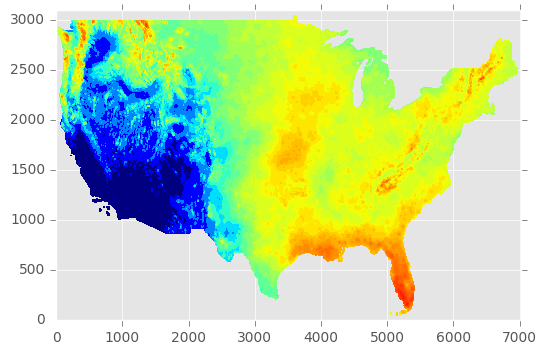

In [35]:
plt.contourf(suite.rain_percents['june'],origin='image',levels = np.linspace(0, .2, 40),cmap=plt.cm.jet,norm = LogNorm())

### Bayesian Updates

In the following section, we plot the results of several updates in succession, of weather data and of roads. The final distribution represents our program's best guess at where you might be, based on the data given.

In [42]:
olin_way = Geolocation(range(6120,6720),range(840,1080))

In [43]:
olin_way.Update(('road name', 'Olin Way'))

0.011108479406719248

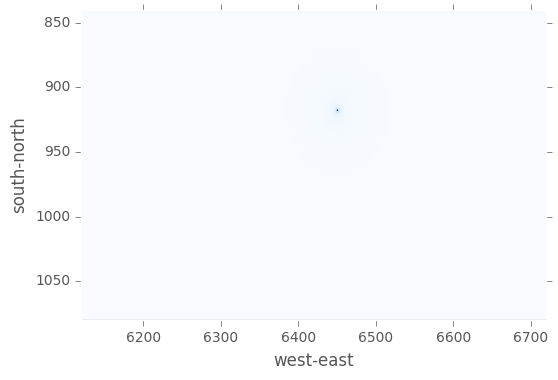

In [44]:
thinkplot.Contour(olin_way, contour=False, pcolor=True)
thinkplot.Config(xlabel='west-east',
                ylabel='south-north',
                axis=[6120, 6720, 1080, 840],
                origin='image')

In [48]:
[olin_way._to_long_lat(coord) for coord in olin_way.CredibleInterval(90)]

[(-73.429166666669062, 42.187499999999282),
 (-69.520833333335887, 41.412499999999312)]

In [49]:
suite = Geolocation(range(6120,6720),range(840,1080))

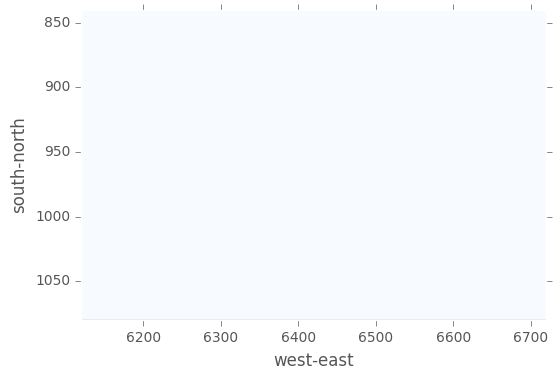

In [50]:
thinkplot.Contour(suite, contour=False, pcolor=True)
thinkplot.Config(xlabel='west-east',
                ylabel='south-north',
                axis=[6120, 6720, 1080, 840],
                origin='image')

In [51]:
suite.Update(("rain",("raining","june")))

0.033243134804665099

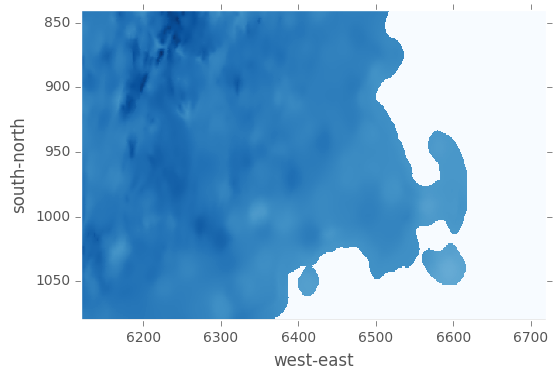

In [52]:
thinkplot.Contour(suite, contour=False, pcolor=True)
thinkplot.Config(xlabel='west-east',
                ylabel='south-north',
                axis=[6120, 6720, 1080, 840],
                origin='image')

In [53]:
suite.Update(("rain",("raining","june")))

0.049081774636565656

In [55]:
suite.Update(("road name", "Oak Avenue"))

0.056068700538873563

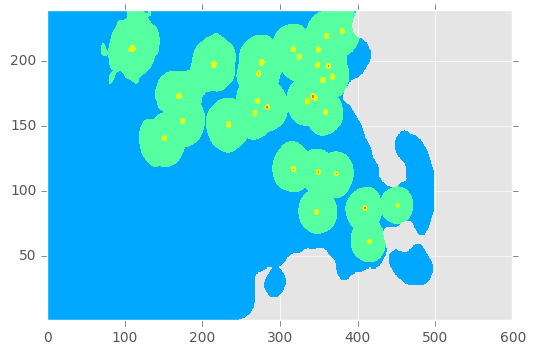

In [76]:
plt.contourf([[suite[(x,y)] for x in range(6120,6720)] for y in range(840,1080)],origin='image',cmap=plt.cm.jet,norm = LogNorm())
plt.show()

*(We had trouble figuring out how to make this plot pretty. The data is there, the levels aren't entirely.)*

## Conclusion and Next Steps

Using geographical data from various sources, we were able to get some interesting results (with only a few vague data points used to update!) that demonstrate the feasibility of using larger areas and more types of data. The road data narrowed down the possible areas a lot, with our simple geometric algorithm, but might be better represented with a Gaussian distribution over a wider area (especially if you don't know how long you've been walking before encountering the road).

The model could with be extended to include a national- or global-scale data range, and a number of other types of data, from other types of simple questions ("can you see a mountain range?" "what color is the dirt?" "what kinds of trees can you see?"), but for now, we think this a reasonable proof-of-concept.